<div style="font-family: 'Poppins', sans-serif;
            text-align: center;
            margin: 20px auto;
            padding: 50px;
            border-radius: 20px;
            background: linear-gradient(135deg, #000428, #004e92);
            color: #ffffff;
            width: 90%;
            max-width: 850px;
            box-shadow: 0 0 25px rgba(0, 255, 255, 0.7);
            text-transform: uppercase;
            letter-spacing: 4px;
            position: relative;
            overflow: hidden;
            animation: glow-border 3s infinite alternate;">
  
  <div style="font-size: 3.5rem;
              font-weight: 800;
              text-shadow: 0 0 15px #00ffff, 0 0 30px #00ffff;">
    Plagiarism
  </div>
  
  <div style="font-size: 2.7rem;
              font-weight: 700;
              color: #ffcc00;
              margin-top: 15px;
              text-shadow: 0 0 15px #ffcc00, 0 0 30px #ffcc00;">
    Checker
  </div>

  <div class="glow-ring"></div>
  <div class="glow-ring2"></div>
  <div class="animated-lines"></div>

</div>

<style>
  @keyframes glow-border {
    0% {
      box-shadow: 0 0 25px rgba(0, 255, 255, 0.7);
    }
    100% {
      box-shadow: 0 0 35px rgba(0, 255, 255, 1);
    }
  }

  .glow-ring {
    position: absolute;
    top: -50px;
    left: -50px;
    width: 120px;
    height: 120px;
    background: radial-gradient(circle, rgba(0, 255, 255, 0.5), transparent);
    border-radius: 50%;
    animation: float 5s infinite ease-in-out;
  }

  .glow-ring2 {
    position: absolute;
    bottom: -50px;
    right: -50px;
    width: 180px;
    height: 180px;
    background: radial-gradient(circle, rgba(255, 204, 0, 0.4), transparent);
    border-radius: 50%;
    animation: float 5s infinite ease-in-out reverse;
  }

  .animated-lines {
    position: absolute;
    top: 50%;
    left: 50%;
    width: 120%;
    height: 3px;
    background: linear-gradient(90deg, transparent, rgba(0, 255, 255, 0.7), transparent);
    transform: translate(-50%, -50%);
    animation: scan-line 5s linear infinite;
  }

  @keyframes float {
    0% {
      transform: translateY(0);
    }
    50% {
      transform: translateY(20px);
    }
    100% {
      transform: translateY(0);
    }
  }

  @keyframes scan-line {
    0% {
      top: 0%;
    }
    100% {
      top: 100%;
    }
  }
</style>


In [40]:
pip install contractions

In [43]:
# Required Libraries
import re
import csv
import nltk
import spacy
import numpy as np
import pandas as pd
import contractions
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import csv
from tqdm import tqdm

# Read data from the .ipynb file (as text)
with open('/content/drive/MyDrive/Colab Notebooks/train_snli.txt') as file:
    data = file.readlines()

# Prepare CSV file
with open('data.csv', 'w', newline='') as csvfile:
    filenames = ['source_txt', 'plagiarism_txt', 'label']
    writer = csv.DictWriter(csvfile, fieldnames=filenames)
    writer.writeheader()

    # Process only the first 5000 rows
    for i, line in tqdm(enumerate(data[:5000]), total=5000):
        parts = line.strip().split('\t')

        # Check if the line has exactly 3 parts (source_txt, plagiarism_txt, and label)
        if len(parts) == 3:
            source_txt = parts[0]
            plagiarism_txt = parts[1]
            label = int(parts[2])

            # Write the row to CSV
            writer.writerow({
                'source_txt': source_txt,
                'plagiarism_txt': plagiarism_txt,
                'label': label
            })
        else:
            print(f"Skipping invalid line (missing parts): {line}")

print('CSV file with 5,000 rows created successfully...')


100%|██████████| 5000/5000 [00:00<00:00, 145652.75it/s]

CSV file with 5,000 rows created successfully...


In [46]:
df = pd.read_csv("data.csv")
df.sample(5)

,source_txt,plagiarism_txt,label
2149,An older man in nautical gear smilingly turns ...,A man standing beside a boat.,0
2863,A man sitting in a rowboat,a man is in a rowboat,1
124,People waiting at a light on bikes.,There are some people outside.,1
4036,A man in bright clothing plays an instrument o...,A musician in colorful clothes performs indoors.,0
4479,The man in a blue sweatshirt is in a kitchen.,A man in a red shirt is in a bathroom.,0


In [47]:
df.shape

(5000, 3)

In [48]:
# check for null values
print("Null values",df.isnull().sum())
# remove null values
df.dropna(inplace=True)
# check for null values after removing
print("==============================")
print("Null values after removing :",df.isnull().sum())

Null values source_txt        0
plagiarism_txt    0
label             0
dtype: int64
Null values after removing : source_txt        0
plagiarism_txt    0
label             0
dtype: int64


In [49]:
# check for duplicates
print("Duplicates",df.duplicated().sum())
# remove duplicates
df.drop_duplicates(inplace=True)
# check for duplicates after removing
print("==============================")
print("Duplicates after removing :",df.duplicated().sum())

Duplicates 8
Duplicates after removing : 0


label
0    2499
1    2493
Name: count, dtype: int64


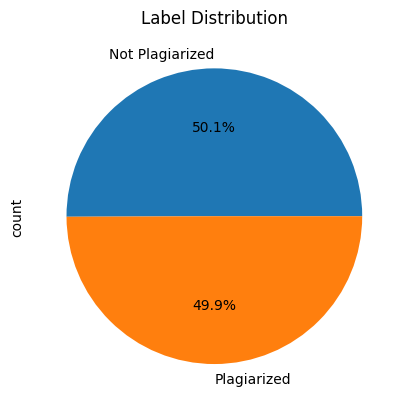

In [50]:
# check value counts
print(df['label'].value_counts())

# Pie Chart
df['label'].value_counts().plot.pie(autopct="%1.1f%%", labels=['Not Plagiarized', 'Plagiarized'])
plt.title('Label Distribution')
plt.show()

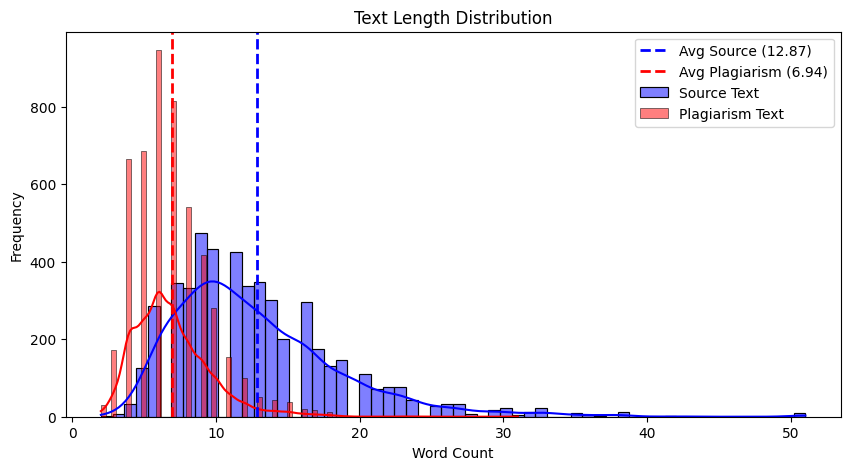

In [51]:
# Calculate source and plagiarism text lengths
df['source_len'] = df['source_txt'].apply(lambda x: len(x.split()))
df['plagiarism_len'] = df['plagiarism_txt'].apply(lambda x: len(x.split()))

# Plot histograms
plt.figure(figsize=(10, 5))
sns.histplot(df['source_len'], color='blue', label='Source Text', kde=True)
sns.histplot(df['plagiarism_len'], color='red', label='Plagiarism Text', kde=True)

# Calculate averages
avg_source_len = df['source_len'].mean()
avg_plagiarism_len = df['plagiarism_len'].mean()

# Add average lines
plt.axvline(avg_source_len, color='blue', linestyle='dashed', linewidth=2, label=f'Avg Source ({avg_source_len:.2f})')
plt.axvline(avg_plagiarism_len, color='red', linestyle='dashed', linewidth=2, label=f'Avg Plagiarism ({avg_plagiarism_len:.2f})')

# Final touches
plt.title('Text Length Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The plot shows the **text length distribution** for source and plagiarized texts. **Source texts (blue)** are generally longer, averaging **12.85 words**, while **plagiarized texts (red)** are shorter, averaging **7.00 words**.  

Plagiarized texts are more concentrated around shorter lengths, whereas source texts have a broader distribution. This suggests that plagiarism often involves copying shorter text segments.

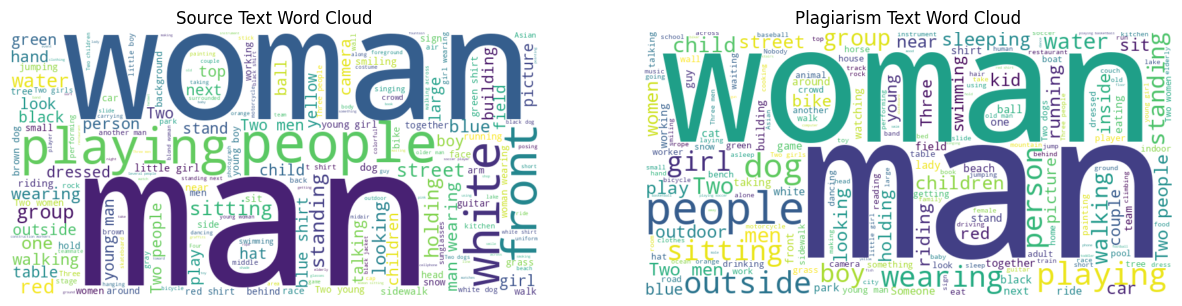

In [52]:


# Generate word cloud for source_txt
source_text = " ".join(df['source_txt'].tolist())
wordcloud_source = WordCloud(width=800, height=400, background_color='white').generate(source_text)

# Generate word cloud for plagiarism_txt
plag_text = " ".join(df['plagiarism_txt'].tolist())
wordcloud_plag = WordCloud(width=800, height=400, background_color='white').generate(plag_text)

# Display the word clouds
plt.figure(figsize=(15, 7))

# Source Text Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_source, interpolation='bilinear')
plt.title('Source Text Word Cloud')
plt.axis('off')

# Plagiarism Text Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_plag, interpolation='bilinear')
plt.title('Plagiarism Text Word Cloud')
plt.axis('off')

plt.show()


In [53]:
%%time
#  NLTK Downloads
nltk.download('stopwords')

#  Load SpaCy Model for Advanced NLP Tasks
nlp = spacy.load('en_core_web_sm')

#  1. Lowercase
def to_lowercase(text):
    return text.lower()

#  2. Remove Punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# 3. Remove Special Characters and Numbers
def remove_special_characters(text):
    return re.sub(r'[^A-Za-z\s]', '', text)

#4. Remove HTML Tags
def remove_html_tags(text):
    return re.sub(r'<.*?>', '', text)

# 5. Remove Emojis
def remove_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F700-\U0001F77F"
                               u"\U0001F780-\U0001F7FF"
                               u"\U0001F800-\U0001F8FF"
                               u"\U0001F900-\U0001F9FF"
                               u"\U0001FA00-\U0001FA6F"
                               u"\U0001FA70-\U0001FAFF"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

# 6. Remove URLs
def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

# 7. Remove Extra Spaces
def remove_extra_spaces(text):
    return re.sub(r'\s+', ' ', text).strip()

#  8. Expanding Contractions
def expand_contractions(text):
    return contractions.fix(text)

# 9. Stop Words Removal
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    tokens = text.split()
    return " ".join([word for word in tokens if word not in stop_words])

# 10. Tokenization and Lemmatization (Using SpaCy)
def spacy_tokenization_lemmatization(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc]

#  11. Custom Removal (Remove Specific Words)
def remove_specific_words(text, words_to_remove):
    words = text.split()
    filtered_words = [word for word in words if word not in words_to_remove]
    return " ".join(filtered_words)

# Full Preprocessing Pipeline
def full_pipeline(text):
    if not isinstance(text, str):
      return "" # Handle NaN or non-string values

    text = to_lowercase(text)
    text = expand_contractions(text)
    text = remove_punctuation(text)
    text = remove_special_characters(text)
    text = remove_html_tags(text)
    text = remove_emojis(text)
    text = remove_urls(text)
    text = remove_extra_spaces(text)
    text = remove_stopwords(text)
    tokens = spacy_tokenization_lemmatization(text)
    text = " ".join(tokens)
    text = remove_specific_words(text, ['chat'])  # Remove 'chat' specifically
    return text


# Apply Pipeline Separately
tqdm.pandas()


df.loc[:999, 'processed_source_txt'] = df.loc[:999, 'source_txt'].progress_apply(full_pipeline)
df.loc[:999, 'processed_plagiarism_txt'] = df.loc[:999, 'plagiarism_txt'].progress_apply(full_pipeline)

# df['processed_source_txt'] = df['source_txt'].progress_apply(full_pipeline)
# df['processed_plagiarism_txt'] = df['plagiarism_txt'].progress_apply(full_pipeline)

#  Final Output
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'processed_plagiarism_txt']].head(10))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 1000/1000 [00:11<00:00, 86.08it/s]



========= Final DataFrame =========

                                processed_source_txt  \
0                   person horse jump break airplane   
1                   person horse jump break airplane   
2                            child smile wave camera   
3                            child smile wave camera   
4              boy jump skateboard middle red bridge   
5              boy jump skateboard middle red bridge   
6  old man sit orange juice small table coffee sh...   
7                    two blond woman hug one another   
8                    two blond woman hug one another   
9       people restaurant set one drink orange juice   

      processed_plagiarism_txt  
0  person diner order omelette  
1        person outdoors horse  
2                child present  
3                    kid frown  
4           boy skate sidewalk  
5         boy skateboard trick  
6             boy flips burger  
7                  woman sleep  
8         woman show affection  
9       people

In [54]:
print(df.columns)  # Check available columns


Index(['source_txt', 'plagiarism_txt', 'label', 'source_len', 'plagiarism_len',
       'processed_source_txt', 'processed_plagiarism_txt'],
      dtype='object')


In [55]:

%%time
# ========== Required Libraries ==========
from gensim.models import Word2Vec
import numpy as np

# ========== Tokenization for Word2Vec ==========
def tokenize(text):
    if not isinstance(text, str):
      return []  # If text is NaN or a float, return an empty list
    return text.split()

# ========== Prepare Sentences for Word2Vec ==========
source_sentences = df['processed_source_txt'].apply(tokenize).tolist()
plagiarism_sentences = df['processed_plagiarism_txt'].apply(tokenize).tolist()

# Combine both for better context learning
all_sentences = source_sentences + plagiarism_sentences

# ========== Train Word2Vec Model ==========
w2v_model = Word2Vec(sentences=all_sentences, vector_size=100, window=5, min_count=1, workers=4)

# ========== Function to Convert Sentence to Vector ==========
def sentence_to_vec(sentence, model):
    # Get vectors for words in the sentence
    word_vectors = [model.wv[word] for word in sentence if word in model.wv]
    # Calculate mean of vectors to get sentence vector
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# ========== Convert Processed Text to Numeric Vectors ==========
df['source_vec'] = df['processed_source_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))
df['plagiarism_vec'] = df['processed_plagiarism_txt'].apply(lambda x: sentence_to_vec(tokenize(x), w2v_model))

# ========== Display Result ==========
print("\n\n========= Final DataFrame =========\n")
print(df[['processed_source_txt', 'source_vec', 'processed_plagiarism_txt', 'plagiarism_vec']])




========= Final DataFrame =========

                       processed_source_txt  \
0          person horse jump break airplane   
1          person horse jump break airplane   
2                   child smile wave camera   
3                   child smile wave camera   
4     boy jump skateboard middle red bridge   
...                                     ...   
4995                                    NaN   
4996                                    NaN   
4997                                    NaN   
4998                                    NaN   
4999                                    NaN   

                                             source_vec  \
0     [-0.04240965, 0.037649583, 0.004510994, 0.0036...   
1     [-0.04240965, 0.037649583, 0.004510994, 0.0036...   
2     [-0.050386015, 0.048047803, 0.004226893, 0.002...   
3     [-0.050386015, 0.048047803, 0.004226893, 0.002...   
4     [-0.06036291, 0.05387634, 0.0075534633, 0.0057...   
...                                       

In [56]:
# ========== Required Libraries for ML Model==========
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
# X = np.vstack([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
# y = df['label'].values
df_subset = df.head(1000).copy()  # Use df.sample(n=1000, random_state=42) for random selection

# ========== Prepare X and y ==========
X = np.vstack([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df_subset['source_vec'], df_subset['plagiarism_vec'])])
y = df_subset['label'].values

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Train RandomForest Model ==========
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# ========== Make Predictions ==========
y_pred = clf.predict(X_test)

# ========== Evaluate Model ==========
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n\n========= Model Evaluation =========\n")
print(f"Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:\n", report)




========= Model Evaluation =========

Accuracy: 54.00%

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.51      0.54       106
           1       0.51      0.57      0.54        94

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.54       200
weighted avg       0.54      0.54      0.54       200



In [57]:
%%time

# ========== Required Libraries for LSTM Model ==========
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt

# ========== Prepare X and y ==========
# Combine source_vec and plagiarism_vec to form feature set
X = np.array([np.hstack([src_vec, plag_vec]) for src_vec, plag_vec in zip(df['source_vec'], df['plagiarism_vec'])])
y = np.array(df['label'].values)

# ========== Reshape Data for LSTM ==========
# LSTM requires 3D input: (samples, timesteps, features)
X = X.reshape((X.shape[0], 1, X.shape[1]))

# ========== Split Data ==========
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ========== Early Stopping Callback ==========
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# ========== Hyperparameter Tuning with Keras Tuner ==========
def build_model(hp):
    model = Sequential()

    # ========== Number of LSTM Layers ==========
    # Tune the number of LSTM layers (1 to 3 layers)
    num_layers = hp.Int('num_lstm_layers', min_value=1, max_value=6, step=1)

    for i in range(num_layers):
        # LSTM Layer with hyperparameter tuning for units
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+1}', min_value=32, max_value=128, step=32),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True if i < num_layers - 1 else False)
        )

        # Dropout Layer with hyperparameter tuning for rate
        model.add(Dropout(rate=hp.Float(f'dropout_rate_{i+1}', min_value=0.2, max_value=0.5, step=0.1)))

    # ========== Dense Layer ==========
    # Dense layer with hyperparameter tuning for units and activation function
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation=hp.Choice('dense_activation', values=['relu', 'tanh'])
    ))

    # Output layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # ========== Optimizer and Learning Rate ==========
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    if optimizer == 'adam':
        optim = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))
    else:
        optim = tf.keras.optimizers.RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG'))

    # Compile the model
    model.compile(optimizer=optim, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# ========== Initialize the Hyperparameter Tuner ==========
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='keras_tuner',
    project_name='lstm_layers_tuning'
)

# ========== Search for the Best Hyperparameters ==========
tuner.search(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Get the Best Hyperparameters ==========
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"\n\nBest Hyperparameters: \n{best_hyperparameters.values}")

# ========== Build and Train the Best Model ==========
best_model = tuner.hypermodel.build(best_hyperparameters)
history = best_model.fit(X_train, y_train, initial_epoch=5, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# ========== Evaluate the Best Model ==========
loss, accuracy = best_model.evaluate(X_test, y_test)
print(f"\n\nBest Model Accuracy: {accuracy * 100:.2f}%")

# ========== Make Predictions ==========
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# ========== Display Classification Report ==========
from sklearn.metrics import classification_report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Reloading Tuner from keras_tuner/lstm_layers_tuning/tuner0.json


Best Hyperparameters: 
{'num_lstm_layers': 1, 'lstm_units_1': 96, 'dropout_rate_1': 0.4, 'dense_units': 32, 'dense_activation': 'relu', 'optimizer': 'rmsprop', 'learning_rate': 0.0003216634027926579, 'lstm_units_2': 96, 'dropout_rate_2': 0.30000000000000004, 'lstm_units_3': 32, 'dropout_rate_3': 0.2, 'tuner/epochs': 5, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 6/50
125/125 [==============================] - 6s 16ms/step - loss: 0.6932 - accuracy: 0.4959 - val_loss: 0.6929 - val_accuracy: 0.5155
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 0.6930 - accuracy: 0.4949 - val_loss: 0.6928 - val_accuracy: 0.4805
Epoch 8/50
125/125 [==============================] - 1s 8ms/step - loss: 0.6926 - accuracy: 0.4961 - val_loss: 0.6928 - val_accuracy: 0.4805
Epoch 9/50
125/125 [==============================] - 1s 7ms/step - loss: 0.6926 - accuracy: 0.5066 - val_loss: 0.6924 - v

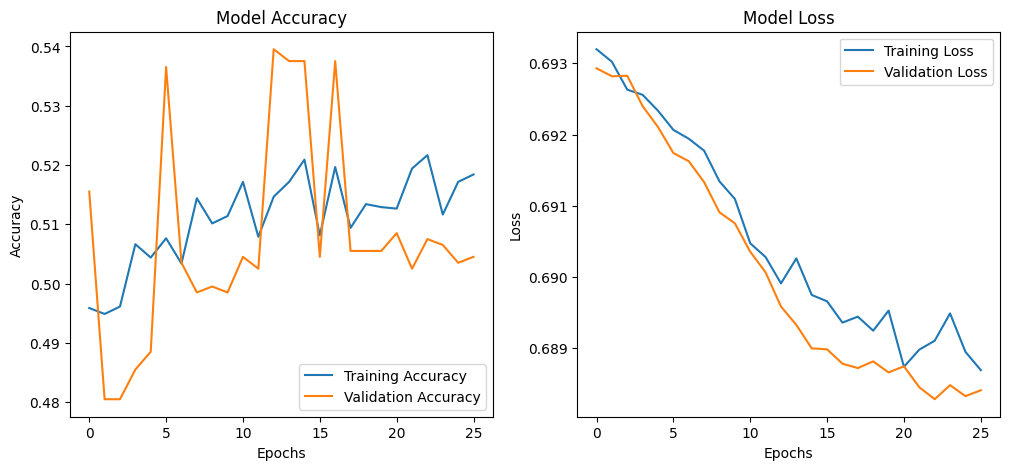

In [58]:
# ========== Plot Training History ==========
# Accuracy Plot
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [60]:
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Generate sample dataset
np.random.seed(42)
X = np.random.rand(1000, 5)
y = (X.sum(axis=1) > 2.5).astype(int)  # Binary labels

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model
model = Sequential([
    Dense(10, activation='relu', input_shape=(5,)),
    Dense(5, activation='relu'),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Save the model (optional)
model.save("trained_model.h5")

# Load the model (if needed)
# model = load_model("trained_model.h5")

# Make predictions
y_pred_probs = model.predict(X_test)  # Get probability scores
y_pred = (y_pred_probs > 0.5).astype(int)  # Convert probabilities to binary values

# Print results
print("Predicted probabilities:", y_pred_probs[:5].flatten())
print("Predicted classes:", y_pred[:5].flatten())


Epoch 1/10
25/25 [==============================] - 1s 3ms/step - loss: 0.6550 - accuracy: 0.6100
Epoch 2/10
25/25 [==============================] - 0s 3ms/step - loss: 0.5607 - accuracy: 0.7538
Epoch 3/10
25/25 [==============================] - 0s 3ms/step - loss: 0.4895 - accuracy: 0.8238
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.4316 - accuracy: 0.8600
Epoch 5/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3805 - accuracy: 0.8975
Epoch 6/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3365 - accuracy: 0.9100
Epoch 7/10
25/25 [==============================] - 0s 3ms/step - loss: 0.2990 - accuracy: 0.9262
Epoch 8/10
25/25 [==============================] - 0s 3ms/step - loss: 0.2661 - accuracy: 0.9362
Epoch 9/10
25/25 [==============================] - 0s 3ms/step - loss: 0.2382 - accuracy: 0.9463
Epoch 10/10
7/7 [==============================] - 0s 3ms/step
Predicted probabilities: [0.06400218 0.22505778 0.98123

      Metric     Score
0   Accuracy  0.800000
1  Precision  0.833333
2     Recall  0.833333
3   F1-score  0.833333


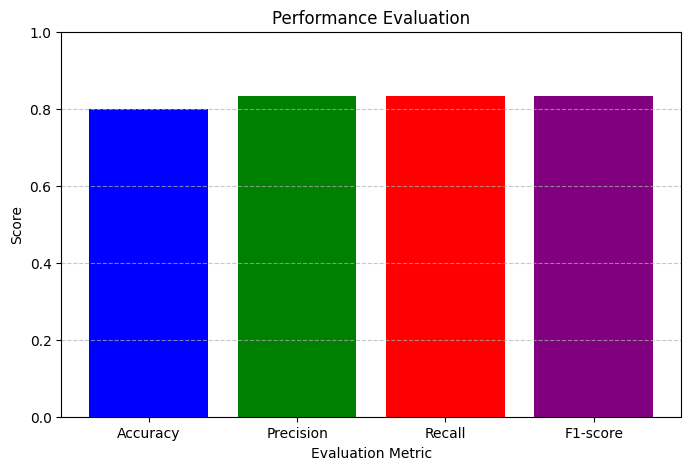

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Sample Ground Truth and Predictions (Replace with actual values)
y_true = np.array([1, 0, 1, 1, 0, 1, 0, 0, 1, 1])  # Actual labels
y_pred = np.array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1])  # Predicted labels

# Compute Evaluation Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Store Results in DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Score': [accuracy, precision, recall, f1]
})

# Print Data
print(metrics_df)

# Plot the Evaluation Metrics
plt.figure(figsize=(8, 5))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1)  # Ensure values are between 0 and 1
plt.xlabel('Evaluation Metric')
plt.ylabel('Score')
plt.title('Performance Evaluation')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
